# ALeRCE classes

https://github.com/ZwickyTransientFacility/ztf-avro-alert

1. **AGN:** Active Galactic Nuclei
1. **Blazar:** Blazar
1. **CV/Nova:** Cataclysmic Variable Star/Nova
1. **Ceph:** Cepheid Variable Star
1. **DSCT:** Delta Scuti Star
1. **EA:** Eclipsing Algol
1. **EB/EW:** Eclipsing Binaries/Eclipsing W Ursa Majoris
1. **LPV:** Long Period Variable
1. **Periodic-Other:** Periodic-Other
1. **QSO:** Quasi-Stellar Object
1. **RRL:** RRLyrae Variable Star
1. **RSCVn:** RS Canum Venaticorum
1. **SLSN:** Super Luminous Supernova
1. **SNII:** Supernova II
1. **SNIIb:** Supernova IIb
1. **SNIIn:** Supernova IIn
1. **SNIa:** Supernova Ia
1. **SNIbc:** Supernova Ibc
1. **TDE:** Tidal disruption event (to remove)
1. **YSO:** Young Stellar Object
1. **ZZ:** ZZ Ceti Stars (to remove)

In [1]:
import sys
sys.path.append('../../') # or just install the module
sys.path.append('../../../flaming-choripan') # or just install the module

In [2]:
%load_ext autoreload
%autoreload 2
from lchandler.surveyexport.alerce_utils import process_df_labels, process_df_detections, keep_only_valid_objs
import numpy as np
import pandas as pd

load_rootdir = '../../../surveys-data'
survey_name = 'alerceZTFv7.1'
uses_corr = False # uses_corr=False only can be used with SNe objects
clean_invalid_objs = True # delete a lot of objects
df_index_names = {
    'oid':'oid', # object id
    'oid_det':'objectId', # object id
    'label':'classALeRCE', # object class name
    'ra':'ra',
    'dec':'dec',
    'band':'fid', # band
    'obs_day':'mjd', # days
    'obs':'magpsf_corr' if uses_corr else 'magpsf', # observations
    'obs_error':'sigmapsf_corr' if uses_corr else 'sigmapsf', # observation errors
}
detections_cols = ['objectId', 'fid', 'mjd', df_index_names['obs'], df_index_names['obs_error']]

### load files and processing
detections_df = pd.read_parquet(f'{load_rootdir}/{survey_name}/detections_with_xmatch')
detections_df, det_objs = process_df_detections(detections_df, df_index_names['oid_det'], df_index_names['oid'], detections_cols, uses_corr=uses_corr, clean_invalid_objs=clean_invalid_objs)
print(f'[detections_df] columns={list(detections_df.columns)} - id={detections_df.index.name}')

labels_df = pd.read_csv(f'{load_rootdir}/{survey_name}/dfcrossmatches_prioritized_v7.0.1.csv')
labels_df, label_objs = process_df_labels(labels_df, df_index_names['oid'], det_objs)
print(f'[labels] columns={list(labels_df.columns)} - id={labels_df.index.name}')

outliers_df = pd.read_csv(f'{load_rootdir}/{survey_name}/outliers.csv')

### filter
valid_objs = list(set(det_objs) & set(label_objs))
labels_df = keep_only_valid_objs(labels_df, valid_objs)
detections_df = keep_only_valid_objs(detections_df, valid_objs)

### print info
classes = set(labels_df[df_index_names['label']].values)
print('classes:', classes)

../../lchandler/surveyexport/alerce_utils.py:81: UserWarning: only use uses_corr=False with SNe objects
  warnings.warn('only use uses_corr=False with SNe objects')


[detections_df] columns=['fid', 'mjd', 'magpsf', 'sigmapsf'] - id=oid
[labels] columns=['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec'] - id=oid
classes: {'TDE', 'Blazar', 'DSCT', 'QSO', 'LPV', 'NLAGN', 'RRL', 'EA', 'SNIbc', 'Ceph', 'SLSN', 'AGN', 'RSCVn', 'NLQSO', 'SNII', 'SNIIn', 'SNIIb', 'CV/Nova', 'ZZ', 'EB/EW', 'SNIa', 'Periodic-Other', 'YSO'}


In [3]:
detections_df.info()
detections_df[:10]

<class 'pandas.core.frame.DataFrame'>
Index: 1032591 entries, ZTF18aavejan to ZTF20abcxmfu
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   fid       1032591 non-null  int64  
 1   mjd       1032591 non-null  float64
 2   magpsf    1032591 non-null  float32
 3   sigmapsf  1032591 non-null  float32
dtypes: float32(2), float64(1), int64(1)
memory usage: 31.5+ MB


,fid,mjd,magpsf,sigmapsf
oid,,,,
ZTF18aavejan,1,58307.352859,19.103745,0.150523
ZTF18aavejan,1,58812.120914,18.976879,0.154910
ZTF18aavejan,1,58376.211956,19.124577,0.131040
ZTF18aavejan,1,58812.111169,19.083048,0.168238
ZTF18aavejan,1,59038.288241,19.032909,0.166986
ZTF18aavejan,1,58612.413391,19.403605,0.178850
ZTF18aavejan,1,58377.257118,18.993353,0.135941
ZTF18aavejan,1,58776.122396,19.255226,0.119648
ZTF18aavejan,1,58429.170671,19.151890,0.176973


In [4]:
labels_df.info()
labels_df[:10]

<class 'pandas.core.frame.DataFrame'>
Index: 18694 entries, ZTF19aapcxhy to ZTF18acbvwsq
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   classALeRCE        18694 non-null  object 
 1   ra                 18694 non-null  float64
 2   dec                18694 non-null  float64
 3   period             988 non-null    object 
 4   source             18694 non-null  object 
 5   id_source          18694 non-null  object 
 6   class_source       18694 non-null  object 
 7   separation_arcsec  18694 non-null  float64
dtypes: float64(3), object(5)
memory usage: 1.3+ MB


,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
oid,,,,,,,,
ZTF19aapcxhy,AGN,154.202129,18.723076,NaN,Oh2015,5.877420127343739e+17,AGN_galaxy_dominated,0.227455
ZTF18abwtbad,AGN,51.846346,0.739559,NaN,Oh2015,5.877315136939624e+17,AGN_galaxy_dominated,0.084636
ZTF18acvgdfy,AGN,134.407409,5.472596,NaN,Oh2015,5.877327033915148e+17,AGN_galaxy_dominated,0.087190
ZTF18aadyxlg,AGN,125.577004,33.091120,NaN,Oh2015,5.880133827239608e+17,AGN_galaxy_dominated,0.073570
ZTF19aapuscr,AGN,199.102327,-2.090396,NaN,Oh2015,5.87724649802236e+17,AGN_galaxy_dominated,0.038667
ZTF19aanxuxz,AGN,212.636953,-2.822530,NaN,Oh2015,5.877297769066006e+17,AGN_galaxy_dominated,0.181073
ZTF19aaohxwd,AGN,175.347895,21.936834,NaN,Oh2015,5.877420610690746e+17,AGN_galaxy_dominated,0.150095
ZTF19aansigk,AGN,177.519279,21.042260,NaN,Oh2015,5.880236707797402e+17,AGN_galaxy_dominated,0.160927
ZTF18aceqjzp,AGN,139.303760,37.075558,NaN,Oh2015,5.882978641805313e+17,AGN_galaxy_dominated,0.456351


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


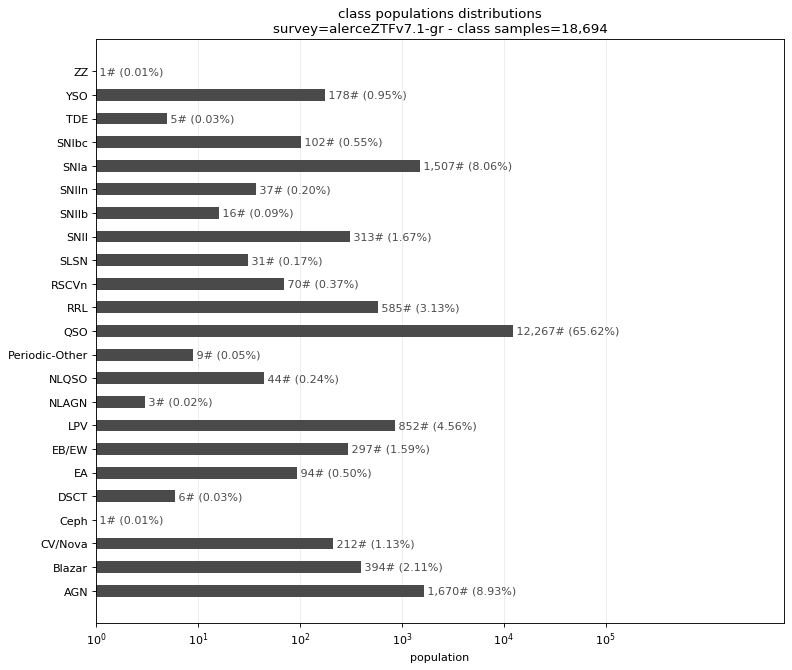

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lchandler.surveyexport.dictionary_creator import LightCurveDictionaryCreator

band_dictionary = {
    'g':1,
    'r':2,
}
args = [survey_name, detections_df, labels_df, band_dictionary, df_index_names]
kwargs = {
    'dataframe_obs_uses_flux':False,
    'zero_point':48.6,
}
lcDictionaryCreator = LightCurveDictionaryCreator(*args, **kwargs)
#print(lcDictionaryCreator)
lcDictionaryCreator.plot_class_distribution(uses_log_scale=1)

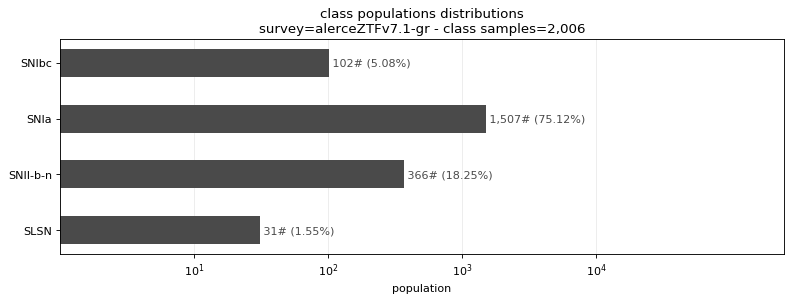

In [6]:
DF_SN_LIST = ['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIa', 'SNIbc']

#mode = 'raw'
#mode = 'simple'
#mode = 'transients'
#mode = 'RRCeph'
mode = 'onlySNe'
#mode = 'onlySNe-SLSN'

if mode=='simple':
    invalid_classes = []
    query_classes = []
    to_merge_classes_dic = {'SN':DF_SN_LIST,}
    
elif mode=='onlySNe':
    kwargs = {
        'invalid_classes':[],
        'query_classes':DF_SN_LIST,
        'merge_classes_dict':{
            'SNII-b-n':['SNII', 'SNIIb', 'SNIIn'],
        },
    }
elif mode=='onlySNe-SLSN':
    kwargs = {
        'invalid_classes':[],
        'query_classes':[sn for sn in DF_SN_LIST if not sn=='SLSN'],
        'merge_classes_dict':{
            'SNII-b-n':['SNII', 'SNIIb', 'SNIIn'],
        },
    }

elif mode=='onlySNIa':
    kwargs = {
        'invalid_classes':[],
        'query_classes':DF_SN_LIST,
        'merge_classes_dict':{
            'non-SNIa':['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIbc'],
        },
    }

elif mode=='RRCeph':
    invalid_classes = []
    query_classes = ['RRL','Ceph']
    to_merge_classes_dic = {}

lcDictionaryCreator.update_labels_df(**kwargs)
lcDictionaryCreator.plot_class_distribution(uses_log_scale=1)
#assert 0

In [7]:
assert 0

AssertionError: 

In [ ]:
%load_ext autoreload
%autoreload 2

description = 'ZTF Alerce'
save_folder = f'../../../surveys-save'
kwargs = {
    'band_names':list(band_dictionary.keys()),
    #'to_export_bands':['g','r'],
    'filename_extra_parameters':{
        'mode':mode,
    },
    'outliers_df':outliers_df,
}
lcdataset = lcDictionaryCreator.export_dictionary(description, save_folder, **kwargs)

In [ ]:
print(lcdataset)

In [ ]:
import flamingchoripan.lists as lists
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve

lcset = lcdataset['raw']
lcobj, lcobj_name = lcset.get_random_lcobj()
lcobj_name = 'ZTF20aadvaoi';lcobj = lcset[lcobj_name].copy()
lcobj.clean_small_cadence() # test
fig, ax = plt.subplots(1,1, figsize=(12,5))
for kb,b in enumerate(lcset.band_names):
    plot_lightcurve(ax, lcobj, b, f'{b} obs')
ax.set_title(f'survey={lcset.survey} - obj={lcobj_name} [{lcset.class_names[lcobj.y]}]')
ax.set_xlabel('time [days]')
ax.set_ylabel('observation [flux]')
ax.legend()
ax.grid(alpha=0.5)